# Soft Proposal Networks 
## pointing localization demo
*please follow the README to train a SPN model before you run this demo*

## global options

In [1]:
opt = {
    model_path = '../logs/SP-VGGNet-VOC2007/model_best.t7',
    image_path = './sample.jpg',
    class_names = {
        'aeroplane','bicycle','bird','boat','bottle','bus','car', 
        'cat','chair','cow','diningtable','dog','horse','motorbike', 
        'person','pottedplant','sheep','sofa','train','tvmonitor'}
}

## setup

In [2]:
require 'nn'
require 'cudnn'
require 'image'
-- import SP module
require 'cuspn'

### load the SPN model

In [3]:
model = torch.load(opt.model_path)
model = torch.typename(model) == 'nn.DataParallelTable' and model:get(1):cuda() or model:cuda()
print(model:__tostring())

### load a sample image

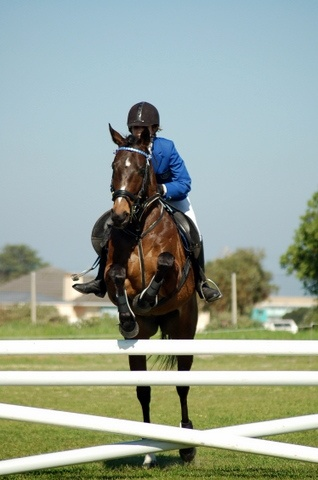

In [4]:
img = image.load(opt.image_path, 3, 'byte'):float()
itorch.image(img)

## prediction

### image preprocessing

In [5]:
input = image.scale(img, 224, 224, 'bilinear')
input[1]  = input[1] - 123.68; input[2]  = input[2] - 116.779; input[3]  = input[3] - 103.939;
input = input:index(1, torch.LongTensor{3, 2, 1}):view(1, 3, 224, 224):cuda()

### feed-forward pass

In [6]:
output = model:forward(input:cuda()):view(-1)

### predict  result

In [7]:
local threshold = 0
scores, indices = output:sort(true)
local counter = 1
object_list = {}
for i=1, #opt.class_names do
    if scores[i] > threshold then
        object = {string.format('%d. %s(%.4f)', counter, opt.class_names[indices[i]], scores[i]), indices[i]}
        print(object[1])
        table.insert(object_list, object)
        counter = counter + 1
    end
end

1. person(11.5655)	
2. horse(8.9658)	

### visualize the proposal map generated by the SP module

In [8]:
SPModule = model:findModules('nn.SoftProposal')[1]
print(SPModule:__tostring())

nn.SoftProposal(14, 14)	


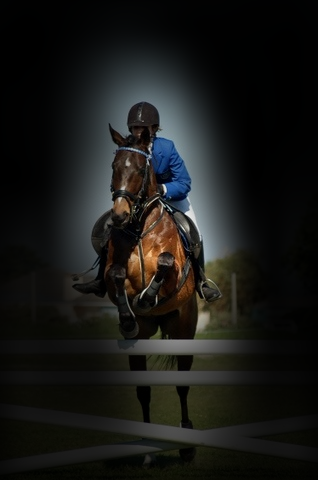

In [9]:
proposal_map = image.scale(SPModule.proposal:clone():float(), img:size(3), img:size(2), 'bicubic')
proposal_map = (proposal_map-proposal_map:min()) / (proposal_map:max() - proposal_map:min())
spotlighted_img = image.rgb2hsv(img)
spotlighted_img[3] = spotlighted_img[3]:cmul(proposal_map)
spotlighted_img = image.hsv2rgb(spotlighted_img)
itorch.image(spotlighted_img)

## pointing localization

In [10]:
function drawMark(src, text, point, size, thinkness, color)
    local mark = torch.zeros(size, size)
    mark[{{(size-thinkness) * 0.5,(size+thinkness) * 0.5}, {}}]:fill(1)
    mark[{{}, {(size-thinkness) * 0.5,(size+thinkness) * 0.5}}]:fill(1)
    mark = image.rotate(mark, math.pi / 4, 'bilinear'):byte()
    local offset = {point[2] - size * 0.5, point[1] - size * 0.5}
    local patch = src[{{}, {offset[1], offset[1] + size - 1}, {offset[2], offset[2] + size - 1}}]
    patch[1]:maskedFill(mark, color[1]); patch[2]:maskedFill(mark, color[2]); patch[3]:maskedFill(mark, color[3])
    src = (src - src:min()) / (src:max() - src:min())
    return image.drawText(src, text, 5, 5, {color = {color[1], color[2], color[3]}, size = 2})
end

In [11]:
function locating(activations, weights, category, image_size)
    -- response map for the object category
    weights = weights[category]:view(1, activations:size(2), 1, 1):expandAs(activations)
    local resp = activations:clone():cmul(weights):sum(2):squeeze():float()
    -- maximum response
    resp = image.scale(resp, img:size(3), img:size(2), 'bicubic')
    local val, idx = resp:view(-1):max(1)
    local nCol  = resp:size(2)
    return {(idx[1] % nCol), math.floor(idx[1] / nCol)}
end

In [12]:
activations = SPModule.output
weights = model:findModules('nn.Linear')[1].weight

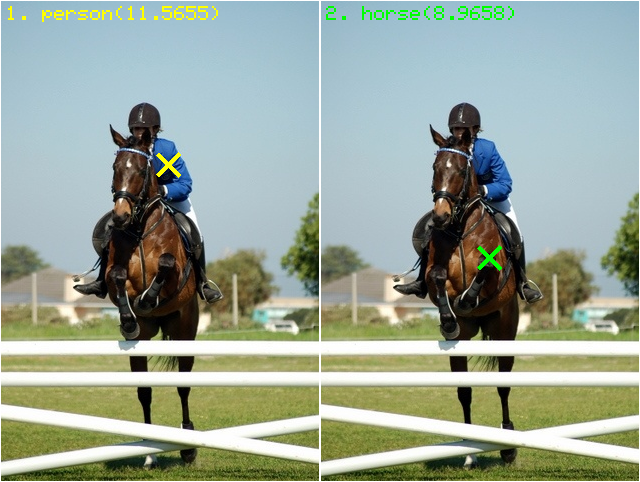

In [13]:
local vis_list = {}
local colors = {{255,255,0}, {0,255,0}, {0,255,255}, {255,0,255}, {255,0,0}}
for i = 1, #object_list do
    table.insert(vis_list, drawMark(img:clone(), object_list[i][1], locating(activations, weights, object_list[i][2], img:size()), 32, 4, colors[i]))
end
itorch.image(vis_list)